<a href="https://colab.research.google.com/github/ChanZH0525/Adv-ML-QwenVLM/blob/main/AML_AA_VLM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install rouge-score
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes
!pip install bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.0 MB/s eta 0:00:00


In [ ]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import zipfile
import pandas as pd
from datasets import load_dataset

In [ ]:

import random

def set_seed(seed=49):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ All random seeds set to {seed}")

# Call it immediately
set_seed(49)
# ============================================

# Then continue with device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✅ All random seeds set to 49


In [ ]:
from google.colab import files
# Upload zip file
print("Upload your VQA-RAD images zip file:")
uploaded_zip = files.upload()

# Upload CSV file
print("\nUpload your CSV file:")
uploaded_csv = files.upload()

# Get filenames
zip_filename = list(uploaded_zip.keys())[0]
csv_filename = list(uploaded_csv.keys())[0]

print(f"\nUploaded files:")
print(f"  Zip: {zip_filename}")
print(f"  CSV: {csv_filename}")

# Extract zip
extract_to = 'vqa_rad_images/'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"\nImages extracted to: {extract_to}")
print("Extraction complete! ✅")

Upload your VQA-RAD images zip file:


Saving VQA_RAD Image.zip to VQA_RAD Image.zip

Upload your CSV file:


Saving vqa_rad_cleaned_train.csv to vqa_rad_cleaned_train.csv

Uploaded files:
  Zip: VQA_RAD Image.zip
  CSV: vqa_rad_cleaned_train.csv

Images extracted to: vqa_rad_images/
Extraction complete! ✅


In [ ]:
# Load CSV
import os
df = pd.read_csv(csv_filename)

# Check structure
print(f"CSV loaded: {len(df)} rows")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample image names:")
print(df['image_name'].head())

# Check extracted folder structure
print(f"\nExtracted folder contents:")
for root, dirs, files in os.walk(extract_to):
    print(f"Folder: {root}")
    if files:
        print(f"Sample files: {files[:5]}")
    if dirs:
        print(f"Subfolders: {dirs}")
    break

CSV loaded: 2244 rows

Columns: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type', 'image_path', 'split']

Sample image names:
0    synpic54610.jpg
1    synpic29265.jpg
2    synpic29265.jpg
3    synpic28602.jpg
4    synpic29265.jpg
Name: image_name, dtype: object

Extracted folder contents:
Folder: vqa_rad_images/
Sample files: ['synpic39240.jpg', 'synpic9872.jpg', 'synpic25758.jpg', 'synpic41325.jpg', 'synpic55245.jpg']


In [ ]:
# Create full image paths
df['full_image_path'] = df['image_name'].apply(lambda x: os.path.join(extract_to, x))

# Verify images exist
df['image_exists'] = df['full_image_path'].apply(os.path.exists)

print(f"Images found: {df['image_exists'].sum()} / {len(df)}")
print(f"Missing images: {(~df['image_exists']).sum()}")

# Keep only valid samples
df_valid = df[df['image_exists']].copy()

print(f"\nValid dataset size: {len(df_valid)}")
print(f"\nQuestion types:")
print(df_valid['question_type'].value_counts())

Images found: 2244 / 2244
Missing images: 0

Valid dataset size: 2244

Question types:
question_type
PRES            801
POS             314
ABN             201
OTHER           196
MODALITY        185
SIZE            170
PLANE           120
ATTRIB           88
ORGAN            59
COLOR            52
COUNT            24
ATTRIB, PRES     10
POS, PRES        10
ABN, POS          5
COLOR, PRES       3
PRES, SIZE        2
COLOR, SIZE       2
ATTRIB, SIZE      1
ABN, PRES         1
Name: count, dtype: int64


In [ ]:
# Keep only essential columns
columns_to_keep = [
    'image_name',
    'question',
    'answer',
    'question_type',
    'answer_type',
    'image_organ',
    'split',
    'full_image_path',
    'image_exists'
]

df_valid = df_valid[columns_to_keep].copy()

print(f"Cleaned dataset columns: {df_valid.columns.tolist()}")
print(f"Dataset size: {len(df_valid)}")
print(f"\nFirst few rows:")
print(df_valid.head())

Cleaned dataset columns: ['image_name', 'question', 'answer', 'question_type', 'answer_type', 'image_organ', 'split', 'full_image_path', 'image_exists']
Dataset size: 2244

First few rows:
        image_name                                      question      answer  \
0  synpic54610.jpg            are regions of the brain infarcted         yes   
1  synpic29265.jpg                are the lungs normal appearing          no   
2  synpic29265.jpg           is there evidence of a pneumothorax          no   
3  synpic28602.jpg  what type of imaging does this not represent  ultrasound   
4  synpic29265.jpg                    is this a mri of the chest          no   

  question_type answer_type image_organ  split  \
0          PRES      CLOSED        HEAD  Train   
1           ABN      CLOSED       CHEST  Train   
2          PRES      CLOSED       CHEST  Train   
3      MODALITY        OPEN       CHEST  Train   
4      MODALITY      CLOSED       CHEST  Train   

                  full_image_

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Use existing split column to separate the pool
train_full = df_valid[df_valid['split'] == 'Train'].reset_index(drop=True)
test_df = df_valid[df_valid['split'] == 'Test'].reset_index(drop=True)

print(f"Original splits from CSV:")
print(f"Train Pool: {len(train_full)}")
print(f"Test Set: {len(test_df)}")

# 2. Create stratified validation split from train_full (20%)
# Added 'stratify' parameter here
train_df, val_df = train_test_split(
    train_full,
    test_size=0.15,
    random_state=42,
    stratify=train_full['answer_type']
)

print(f"\nFinal splits (with Stratification):")
print(f"Train: {len(train_df)}")
print(f"Val:   {len(val_df)}")
print(f"Test:  {len(test_df)}")

# Optional: Verify the stratification worked
print("\n--- Stratification Check (Answer Type Distribution) ---")
print(f"Train Distribution:\n{train_df['answer_type'].value_counts(normalize=True)}")
print(f"Val Distribution:\n{val_df['answer_type'].value_counts(normalize=True)}")

Original splits from CSV:
Train Pool: 1793
Test Set: 451

Final splits (with Stratification):
Train: 1524
Val:   269
Test:  451

--- Stratification Check (Answer Type Distribution) ---
Train Distribution:
answer_type
CLOSED    0.571522
OPEN      0.428478
Name: proportion, dtype: float64
Val Distribution:
answer_type
CLOSED    0.572491
OPEN      0.427509
Name: proportion, dtype: float64


In [ ]:
# Analyze answer lengths
train_lengths = train_df['answer'].apply(lambda x: len(x.split())).describe()
test_lengths = val_df['answer'].apply(lambda x: len(x.split())).describe()

print("Training set answer lengths:")
print(train_lengths)
print("\nTest set answer lengths:")
print(test_lengths)

# By answer type
closed_lengths = df_valid[df_valid['answer_type']=='CLOSED']['answer'].apply(len)
open_lengths = df_valid[df_valid['answer_type']=='OPEN']['answer'].apply(len)

print(f"\nClosed: {closed_lengths.mean():.1f} words")
print(f"Open: {open_lengths.mean():.1f} words")
print(f"Open 95th percentile: {open_lengths.quantile(0.95):.0f} words")

Training set answer lengths:
count    1524.000000
mean        1.647638
std         1.569527
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: answer, dtype: float64

Test set answer lengths:
count    269.000000
mean       1.609665
std        1.508700
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: answer, dtype: float64

Closed: 3.0 words
Open: 15.4 words
Open 95th percentile: 43 words


In [ ]:
from torchvision import transforms

# Define image preprocessing pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from transformers import AutoTokenizer

# Load Qwen3-4B tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    trust_remote_code=True
)

# Add special image token
special_tokens = {"additional_special_tokens": ["<image>"]}
tokenizer.add_special_tokens(special_tokens)

# Verify
print(f"Vocabulary size: {len(tokenizer)}")
print(f"Image token ID: {tokenizer.convert_tokens_to_ids('<image>')}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Vocabulary size: 151670
Image token ID: 151669


In [ ]:
import copy
from torch.utils.data import Dataset

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, image_transform):
        self.df = df
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and transform image
        image = Image.open(row['full_image_path']).convert('RGB')
        pixel_values = self.image_transform(image)

        # Construct strings
        prompt = f"<image>\nQuestion: {row['question']}\nAnswer: "
        full_text = prompt + f"{row['answer']}{self.tokenizer.eos_token}"

        # Tokenize
        full_encodings = self.tokenizer(full_text, truncation=True, max_length=128, padding='max_length', return_tensors="pt")

        input_ids = full_encodings['input_ids'].squeeze(0)
        attention_mask = full_encodings['attention_mask'].squeeze(0)

        # Create labels: NO QUESTION MASKING
        labels = input_ids.clone()

        # Only mask padding tokens (keep question tokens)
        labels[attention_mask == 0] = -100

        return {
            'image': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'answer_text': row['answer'],
            'question_type': row['question_type'],
            'answer_type': row['answer_type'],
            'image_organ': row['image_organ']
        }

# Create datasets
batch_size = 4
train_dataset = VQADataset(train_df, tokenizer, image_transform)
val_dataset = VQADataset(val_df, tokenizer, image_transform)
test_dataset = VQADataset(test_df, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Datasets created WITHOUT answer-only loss masking:")
print(f"⚠️  Model will now train on BOTH question and answer tokens")
print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Datasets created WITHOUT answer-only loss masking:
⚠️  Model will now train on BOTH question and answer tokens
Train: 1524 samples
Val: 269 samples
Test: 451 samples


In [ ]:


import open_clip

model, preprocess = open_clip.create_model_from_pretrained(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
vision_encoder = model.visual  # Extract vision encoder only

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
# Freeze all parameters
for param in vision_encoder.parameters():
    param.requires_grad = False

# Move to device
vision_encoder = vision_encoder.to(device)
vision_encoder.eval()

# Verify
print(f"Vision encoder loaded")
print(f"Parameters frozen: {not next(vision_encoder.parameters()).requires_grad}")
print(f"Device: {next(vision_encoder.parameters()).device}")

Vision encoder loaded
Parameters frozen: True
Device: cuda:0


In [ ]:
# Check for the correct attribute
if hasattr(vision_encoder, 'embed_dim'):
    print(f"Output dimension: {vision_encoder.embed_dim}")
elif hasattr(vision_encoder, 'num_features'):
    print(f"Output dimension: {vision_encoder.num_features}")
else:
    # Test with dummy input
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        output = vision_encoder(dummy_input)
    print(f"Output dimension: {output.shape[-1]}")

Output dimension: 512


Input image shape: torch.Size([1, 3, 224, 224])
Output features shape: torch.Size([1, 512])
Feature sample (first 10 values): tensor([ -2.2011,   0.7078, -22.0750,  -1.2604,  -1.0986,   3.8557,   1.0789,
          0.9516,  -1.6363,  -0.0391], device='cuda:0')


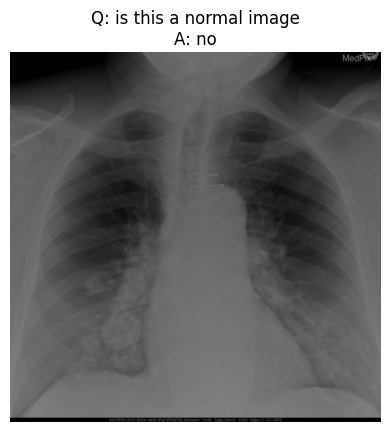

In [ ]:
# Get a sample from train dataset
row_idx = 0 # Example row index
sample = train_df.iloc[row_idx]
image = Image.open(sample['full_image_path']).convert('RGB') # Load image using full_image_path

# Apply preprocessing
image_tensor = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Extract features
with torch.no_grad():
    features = vision_encoder(image_tensor)

print(f"Input image shape: {image_tensor.shape}")
print(f"Output features shape: {features.shape}")
print(f"Feature sample (first 10 values): {features[0, :10]}")

# Visualize the image
plt.imshow(image)
plt.title(f"Q: {sample['question']}\nA: {sample['answer']}")
plt.axis('off')
plt.show()

In [ ]:
import torch.nn as nn

class Projector(nn.Module):
    def __init__(self, vision_dim=512, llm_dim=2560):
        super().__init__()
        # Wrap everything in nn.Sequential so PyTorch registers the parameters
        self.proj = nn.Sequential(
            # Stage 1: 512 -> 1024
            nn.Linear(vision_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),

            # Stage 2: 1024 -> 2048
            nn.Linear(1024, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Dropout(0.1),

            # Stage 3: 2048 -> 2560 (LLM Hidden Size)
            nn.Linear(2048, llm_dim)
        )

    def forward(self, x):
        # Now self.proj is defined and contains all layers
        return self.proj(x)

# Create projector
# Ensure 'device' is defined (e.g., device = "cuda" if torch.cuda.is_available() else "cpu")
projector = Projector(vision_dim=512, llm_dim=2560).to(device)

print(f"Projector created")
print(f"Trainable parameters: {sum(p.numel() for p in projector.parameters()):,}")

Projector created
Trainable parameters: 7,876,096


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

# 8-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True
)

# Load LLM
llm = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
llm = get_peft_model(llm, lora_config)

print("LLM loaded with LoRA")
llm.print_trainable_parameters()

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

LLM loaded with LoRA
trainable params: 2,949,120 || all params: 4,025,417,216 || trainable%: 0.0733


In [ ]:
class VLMModel(nn.Module):
    def __init__(self, vision_encoder, projector, llm, tokenizer):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.projector = projector
        self.llm = llm
        self.tokenizer = tokenizer
        self.image_token_id = tokenizer.convert_tokens_to_ids('<image>')

    def forward(self, images, input_ids, attention_mask, labels=None):
        # Extract visual features
        with torch.no_grad():
            visual_features = self.vision_encoder(images)  # [batch, 512]

        # Project to LLM embedding space
        visual_embeds = self.projector(visual_features)
        visual_embeds = visual_embeds.unsqueeze(1)

        # Get text embeddings
        text_embeds = self.llm.get_input_embeddings()(input_ids)

        # Find <image> token positions and replace with visual embeddings
        batch_size = input_ids.shape[0]
        for i in range(batch_size):
            image_pos = (input_ids[i] == self.image_token_id).nonzero(as_tuple=True)[0]
            if len(image_pos) > 0:
                text_embeds[i, image_pos[0]] = visual_embeds[i, 0]

        # Forward through LLM
        outputs = self.llm(
            inputs_embeds=text_embeds,
            attention_mask=attention_mask
        )

        # Compute loss on ALL tokens (question + answer)
        loss = None
        if labels is not None:
            logits = outputs.logits

            # Shift for causal LM: predict next token
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            # Only ignore padding tokens (-100), train on everything else
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                          shift_labels.view(-1))

            # Create outputs with loss
            from transformers.modeling_outputs import CausalLMOutputWithPast
            outputs = CausalLMOutputWithPast(loss=loss, logits=logits)

        return outputs


# Recreate VLM without answer-only masking
vlm_model = VLMModel(vision_encoder, projector, llm, tokenizer)
print("VLM model created WITHOUT answer-only loss")
print("⚠️  Model will train on BOTH question and answer tokens")
print("Note: Only padding tokens are masked in the dataset")

VLM model created WITHOUT answer-only loss
⚠️  Model will train on BOTH question and answer tokens
Note: Only padding tokens are masked in the dataset


In [ ]:
import copy
from peft import get_peft_model_state_dict, set_peft_model_state_dict

class EarlyStopping:
    def __init__(self, patience=2, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves ONLY the trainable parts of the model.'''
        if self.verbose:
            print(f'Validation loss decreased. Saving best model state...')

        # 1. Capture Projector state
        projector_state = copy.deepcopy(model.projector.state_dict())

        # 2. Capture ONLY the LoRA adapter weights (NOT the whole LLM)
        lora_state = get_peft_model_state_dict(model.llm)

        self.best_state = {
            'projector': projector_state,
            'llm_lora': lora_state
        }

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

In [ ]:
from torch.optim import AdamW

# Get trainable parameters (projector + LoRA)
trainable_params = [
    {'params': projector.parameters(), 'lr': 0.0001},
    {'params': llm.parameters(), 'lr': 0.00005}
]

# Create optimizer
optimizer = AdamW(trainable_params, weight_decay=0.01)

# Define gradient accumulation steps before usage
gradient_accumulation_steps = 4

# Calculate total training steps
steps_per_epoch = len(train_loader) // gradient_accumulation_steps
num_epochs = 20
warmup_steps = 200
total_steps = num_epochs * steps_per_epoch

print(f"Training configuration:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")

# Warmup + Cosine Annealing Scheduler
def lr_lambda(current_step):
    if current_step < warmup_steps:
        # Linear warmup
        return float(current_step) / float(max(1, warmup_steps))
    # Cosine annealing after warmup
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

scheduler = LambdaLR(optimizer, lr_lambda)

# Early stopping config
patience = 2
early_stopping = EarlyStopping(patience=patience, verbose=True)

print(f"  Max epochs: {num_epochs}")
print(f"  Early stopping patience: {patience}")
print(f"  Effective batch size: {batch_size * gradient_accumulation_steps}")

Training configuration:
  Steps per epoch: 95
  Total steps: 1900
  Warmup steps: 200
  Max epochs: 20
  Early stopping patience: 2
  Effective batch size: 16


In [ ]:
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, scheduler, device, gradient_accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    progress_bar = tqdm(train_loader, desc="Training")

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(images, input_ids, attention_mask, labels)
        loss = outputs.loss / gradient_accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()  # ← Step-level LR update
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps

        # Show loss and current LR
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
            'lr': f'{current_lr:.2e}'
        })

    return total_loss / len(train_loader)

In [ ]:
def validate(model, val_loader, device):
    model.eval()
    total_loss = 0

    progress_bar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch in progress_bar:
            # Move batch to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask, labels)
            loss = outputs.loss

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(val_loader)

print("Validation function ready")

Validation function ready


In [ ]:
# Training history
train_losses = []
val_losses = []

print("Starting training with Early Stopping...")

for epoch in range(num_epochs):
    print(f"\n{'='*50}\nEpoch {epoch + 1}/{num_epochs}\n{'='*50}")

    # 1. Train (now passes scheduler)
    train_loss = train_epoch(vlm_model, train_loader, optimizer, scheduler, device, gradient_accumulation_steps)
    train_losses.append(train_loss)

    # 2. Validate
    val_loss = validate(vlm_model, val_loader, device)
    val_losses.append(val_loss)

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    print(f"  Train-Val Gap: {val_loss - train_loss:.4f}")

    # 3. Early Stopping Check
    early_stopping(val_loss, vlm_model)

    if early_stopping.early_stop:
        print("Early stopping triggered. Training halted.")
        break
# After the training loop breaks
print("\nTraining complete!")

# ✅ CRITICAL FIX: Restore best model weights
if early_stopping.best_state:
    best_epoch = np.argmin(val_losses) + 1
    print(f"\nRestoring best model from Epoch {best_epoch} (Val Loss: {min(val_losses):.4f})")

    vlm_model.projector.load_state_dict(early_stopping.best_state['projector'])
    set_peft_model_state_dict(vlm_model.llm, early_stopping.best_state['llm_lora'])

    print("✅ Best model weights restored successfully!")
else:
    print("⚠️ Warning: No best state saved, using final epoch weights")

# Now continue with evaluation...

Starting training with Early Stopping...

Epoch 1/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s, loss=1.8340]



Epoch 1 Summary:
  Train Loss: 3.7377
  Val Loss: 1.8835
  Learning Rate: 4.75e-05
  Train-Val Gap: -1.8542
Validation loss decreased. Saving best model state...

Epoch 2/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.18it/s, loss=1.1465]



Epoch 2 Summary:
  Train Loss: 1.4776
  Val Loss: 1.4005
  Learning Rate: 9.50e-05
  Train-Val Gap: -0.0771
Validation loss decreased. Saving best model state...

Epoch 3/20


Validation: 100%|██████████| 68/68 [00:30<00:00,  2.20it/s, loss=1.1465]



Epoch 3 Summary:
  Train Loss: 1.2883
  Val Loss: 1.3303
  Learning Rate: 9.94e-05
  Train-Val Gap: 0.0419
Validation loss decreased. Saving best model state...

Epoch 4/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.19it/s, loss=1.0596]



Epoch 4 Summary:
  Train Loss: 1.2063
  Val Loss: 1.2904
  Learning Rate: 9.73e-05
  Train-Val Gap: 0.0841
Validation loss decreased. Saving best model state...

Epoch 5/20


Validation: 100%|██████████| 68/68 [00:30<00:00,  2.19it/s, loss=1.0977]



Epoch 5 Summary:
  Train Loss: 1.1418
  Val Loss: 1.2730
  Learning Rate: 9.37e-05
  Train-Val Gap: 0.1311
Validation loss decreased. Saving best model state...

Epoch 6/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.19it/s, loss=1.0479]



Epoch 6 Summary:
  Train Loss: 1.0829
  Val Loss: 1.2709
  Learning Rate: 8.88e-05
  Train-Val Gap: 0.1881
Validation loss decreased. Saving best model state...

Epoch 7/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.17it/s, loss=1.0488]



Epoch 7 Summary:
  Train Loss: 1.0323
  Val Loss: 1.2597
  Learning Rate: 8.26e-05
  Train-Val Gap: 0.2273
Validation loss decreased. Saving best model state...

Epoch 8/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.19it/s, loss=1.0664]



Epoch 8 Summary:
  Train Loss: 1.0013
  Val Loss: 1.2635
  Learning Rate: 7.55e-05
  Train-Val Gap: 0.2622
EarlyStopping counter: 1 out of 2

Epoch 9/20


Validation: 100%|██████████| 68/68 [00:31<00:00,  2.19it/s, loss=1.0459]


Epoch 9 Summary:
  Train Loss: 0.9421
  Val Loss: 1.2762
  Learning Rate: 6.76e-05
  Train-Val Gap: 0.3341
EarlyStopping counter: 2 out of 2
Early stopping triggered. Training halted.

Training complete!

Restoring best model from Epoch 7 (Val Loss: 1.2597)
✅ Best model weights restored successfully!


In [ ]:
def generate_answer(model, image, question, tokenizer, device, answer_type='OPEN', max_length=15):
    model.eval()

    image_tensor = image_transform(image).unsqueeze(0).to(device)
    prompt = f"<image>\nQuestion: {question}\nAnswer:"

    inputs = tokenizer(prompt, return_tensors='pt', padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Answer-type-specific token limits
    if answer_type == 'CLOSED':
        max_new_tokens = 3
        min_new_tokens = 1
    else:  # OPEN
        max_new_tokens = 25
        min_new_tokens = 2

    with torch.no_grad():
        visual_features = model.vision_encoder(image_tensor)
        visual_embeds = model.projector(visual_features).unsqueeze(1)

        text_embeds = model.llm.get_input_embeddings()(input_ids)
        image_pos = (input_ids[0] == model.image_token_id).nonzero(as_tuple=True)[0]
        if len(image_pos) > 0:
            text_embeds[0, image_pos[0]] = visual_embeds[0, 0]

        outputs = model.llm.generate(
            inputs_embeds=text_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            repetition_penalty=1.2
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = answer.split("Answer:")[-1].strip()

    # Post-processing based on answer type
    if answer_type == 'CLOSED':
        # For closed: extract only yes/no, truncate aggressively
        answer = answer.split('.')[0].split('\n')[0].split(',')[0].strip()
    else:
        # For open: allow full sentence but remove trailing artifacts
        answer = answer.split('\n')[0].strip()

    return answer

In [ ]:
def visualize_test_sample(model, test_df, tokenizer, device, sample_idx=None,
                          random_sample=False, answer_type=None):
    """
    Visualize and evaluate a test sample with optional answer type filtering.

    Args:
        model: VLM model
        test_df: Test DataFrame
        tokenizer: Tokenizer
        device: torch device
        sample_idx: Specific index to visualize (None for first)
        random_sample: If True, pick random sample
        answer_type: Filter by 'CLOSED' or 'OPEN' (None for no filter)

    Returns:
        Dictionary with prediction details
    """
    import random

    # Filter by answer type if specified
    if answer_type is not None:
        filtered_df = test_df[test_df['answer_type'] == answer_type].reset_index(drop=True)
        if len(filtered_df) == 0:
            print(f"❌ No samples found with answer_type='{answer_type}'")
            return None
        df_to_use = filtered_df
    else:
        df_to_use = test_df

    # Determine which sample to use
    if random_sample:
        sample_idx = random.randint(0, len(df_to_use) - 1)
    elif sample_idx is None:
        sample_idx = 0  # Default to first sample

    # Get sample
    row = df_to_use.iloc[sample_idx]
    image = Image.open(row['full_image_path']).convert('RGB')

    # Generate prediction
    predicted_answer = generate_answer(
        model,
        image,
        row['question'],
        tokenizer,
        device,
        answer_type=row['answer_type']  # Pass answer type to generation
    )

    # Display image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Question: {row['question']}", fontsize=12, wrap=True)
    plt.tight_layout()
    plt.show()

    # Print details
    print(f"{'='*60}")
    print(f"Sample Index: {sample_idx} (from {answer_type if answer_type else 'ALL'} samples)")
    print(f"Question Type: {row['question_type']}")
    print(f"Answer Type: {row['answer_type']}")
    print(f"Image Organ: {row['image_organ']}")
    print(f"\nQuestion: {row['question']}")
    print(f"Ground Truth: {row['answer']}")
    print(f"Predicted: {predicted_answer}")

    # Check if correct
    gt_lower = row['answer'].lower().strip()
    pred_lower = predicted_answer.lower().strip()

    # Special handling for closed-ended
    if row['answer_type'] == 'CLOSED':
        gt_clean = clean_closed_answer(gt_lower)
        pred_clean = clean_closed_answer(pred_lower)
        correct = gt_clean == pred_clean
        if correct:
            print(f"\n✅ EXACT MATCH! ('{pred_clean}' == '{gt_clean}')")
        else:
            print(f"\n❌ INCORRECT (predicted '{pred_clean}', expected '{gt_clean}')")
    else:
        # Open-ended exact match
        if gt_lower == pred_lower:
            print(f"\n✅ EXACT MATCH!")
        elif pred_lower in gt_lower or gt_lower in pred_lower:
            print(f"\n⚠️  PARTIAL MATCH")
        else:
            print(f"\n❌ INCORRECT")
        correct = gt_lower == pred_lower

    print(f"{'='*60}")

    # Return details
    return {
        'index': sample_idx,
        'question': row['question'],
        'ground_truth': row['answer'],
        'prediction': predicted_answer,
        'question_type': row['question_type'],
        'answer_type': row['answer_type'],
        'correct': correct,
        'image_organ': row['image_organ']
    }

Computing Test Loss: 100%|██████████| 113/113 [00:51<00:00,  2.19it/s]


Final Loss Comparison:
Final Train Loss: 0.9421
Final Val Loss: 1.2762


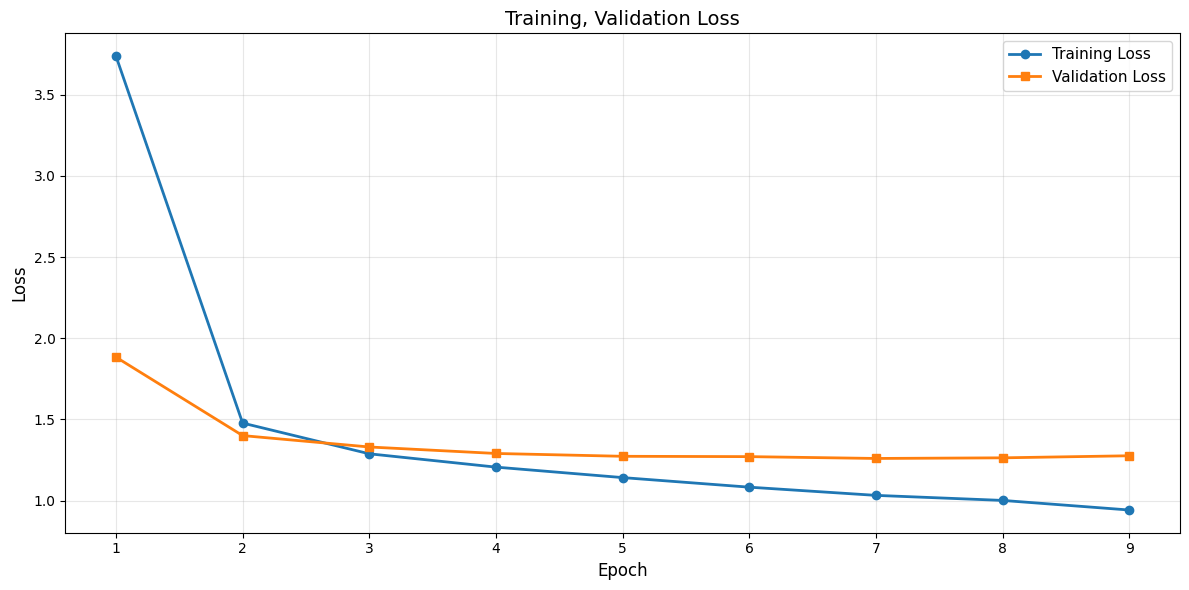

In [ ]:
# After training completes, calculate test loss
def compute_test_loss(model, test_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Computing Test Loss"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(images, input_ids, attention_mask, labels)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(test_loader)

# Calculate test loss
test_loss = compute_test_loss(vlm_model, test_loader, device)

print(f"\nFinal Loss Comparison:")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
#print(f"Test Loss: {test_loss:.4f}")

# Plot all three
plt.figure(figsize=(12, 6))

# Training and validation over epochs
epochs = range(1, len(train_losses) + 1) # Adjusted to match the actual number of completed epochs
plt.plot(epochs, train_losses, marker='o', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, marker='s', label='Validation Loss', linewidth=2)

# Test loss as horizontal line (computed once)
#plt.axhline(y=test_loss, color='red', linestyle='--', linewidth=2, label='Test Loss')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training, Validation Loss', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import nltk
# Remove the nltk.data import
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#from rouge_score import rouge_scorer
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoTokenizer, AutoModel
import re

In [ ]:
def clean_closed_answer(pred):
    """
    Extract yes/no from potentially verbose answers.
    Handles cases like "Yes, there is...", "No signs of...", etc.
    """
    pred = pred.lower().strip()

    # Match "yes" at start of string (with word boundary)
    if re.match(r'^yes\b', pred):
        return "yes"

    # Match "no" at start of string (with word boundary)
    if re.match(r'^no\b', pred):
        return "no"

    # If no clear yes/no pattern, return first word as fallback
    return pred.split()[0] if pred.split() else ""

In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import wordnet as wn

def clean_closed_answer(pred):
    """Extract yes/no from potentially verbose answers."""
    pred = pred.lower().strip()
    if re.match(r'^yes\b', pred):
        return "yes"
    if re.match(r'^no\b', pred):
        return "no"
    return pred.split()[0] if pred.split() else ""


def compute_wbss(pred_text, gt_text):
    """Compute Wu-Palmer Similarity Score between two texts."""
    pred_words = pred_text.lower().split()
    gt_words = gt_text.lower().split()

    if not pred_words or not gt_words:
        return 0.0

    similarities = []
    for pred_word in pred_words:
        pred_synsets = wn.synsets(pred_word)
        if not pred_synsets:
            continue

        max_sim = 0.0
        for gt_word in gt_words:
            gt_synsets = wn.synsets(gt_word)
            if not gt_synsets:
                continue

            for ps in pred_synsets:
                for gs in gt_synsets:
                    sim = ps.wup_similarity(gs)
                    if sim and sim > max_sim:
                        max_sim = sim

        if max_sim > 0:
            similarities.append(max_sim)

    return np.mean(similarities) if similarities else 0.0


def evaluate_comprehensive(model, test_df, tokenizer, device):
    """Simplified comprehensive evaluation with answer-type-specific generation."""

    # Generate all predictions
    print("Generating predictions...")
    predictions = []

    for idx in tqdm(range(len(test_df)), desc="Evaluating"):
        row = test_df.iloc[idx]
        image = Image.open(row['full_image_path']).convert('RGB')

        pred = generate_answer(model, image, row['question'], tokenizer, device,
                              answer_type=row['answer_type'])

        predictions.append({
            'prediction': pred.lower().strip(),
            'ground_truth': row['answer'].lower().strip(),
            'question_type': row['question_type'],
            'answer_type': row['answer_type']
        })

    df = pd.DataFrame(predictions)

    # Compute correctness for each row
    def is_correct(row):
        if row['answer_type'] == 'CLOSED':
            return clean_closed_answer(row['prediction']) == clean_closed_answer(row['ground_truth'])
        else:
            return row['prediction'] == row['ground_truth']

    df['correct'] = df.apply(is_correct, axis=1)

    # Split by answer type
    closed_df = df[df['answer_type'] == 'CLOSED']
    open_df = df[df['answer_type'] == 'OPEN']

    # === CLOSED-ENDED METRICS ===
    closed_acc = (closed_df['correct'].sum() / len(closed_df) * 100) if len(closed_df) > 0 else 0

    # === OPEN-ENDED METRICS ===
    print("\n📊 Computing open-ended metrics...")

    open_metrics = {
        'exact': [],
        'bleu1': [],
        'bleu2': [],
        'bleu3': [],
        'bleu4': [],
        'wbss': []
    }

    smoothing = SmoothingFunction()

    for _, row in tqdm(open_df.iterrows(), total=len(open_df), desc="BLEU/WBSS"):
        pred_tokens = row['prediction'].split()
        gt_tokens = row['ground_truth'].split()

        # Exact match
        open_metrics['exact'].append(1.0 if row['correct'] else 0.0)

        # BLEU scores
        if pred_tokens and gt_tokens:
            open_metrics['bleu1'].append(sentence_bleu([gt_tokens], pred_tokens,
                                                       weights=(1, 0, 0, 0),
                                                       smoothing_function=smoothing.method1))
            open_metrics['bleu2'].append(sentence_bleu([gt_tokens], pred_tokens,
                                                       weights=(0.5, 0.5, 0, 0),
                                                       smoothing_function=smoothing.method1))
            open_metrics['bleu3'].append(sentence_bleu([gt_tokens], pred_tokens,
                                                       weights=(0.33, 0.33, 0.33, 0),
                                                       smoothing_function=smoothing.method1))
            open_metrics['bleu4'].append(sentence_bleu([gt_tokens], pred_tokens,
                                                       weights=(0.25, 0.25, 0.25, 0.25),
                                                       smoothing_function=smoothing.method1))
        else:
            open_metrics['bleu1'].append(0.0)
            open_metrics['bleu2'].append(0.0)
            open_metrics['bleu3'].append(0.0)
            open_metrics['bleu4'].append(0.0)

        # WBSS
        open_metrics['wbss'].append(compute_wbss(row['prediction'], row['ground_truth']))

    # Average open-ended metrics
    open_results = {k: np.mean(v) * 100 if v else 0 for k, v in open_metrics.items()}

    # === PRINT RESULTS ===
    print("\n" + "="*70)
    print(" " * 20 + "EVALUATION RESULTS")
    print("="*70)

    print(f"\n📊 CLOSED-ENDED PERFORMANCE:")
    print(f"   Total: {len(closed_df)}")
    print(f"   Accuracy: {closed_acc:.2f}% ({closed_df['correct'].sum()}/{len(closed_df)})")

    print(f"\n📊 OPEN-ENDED PERFORMANCE:")
    print(f"   Total: {len(open_df)}")
    print(f"   Exact Match:  {open_results['exact']:.2f}%")
    print(f"   BLEU-1:       {open_results['bleu1']:.2f}%")
    print(f"   BLEU-2:       {open_results['bleu2']:.2f}%")
    print(f"   BLEU-3:       {open_results['bleu3']:.2f}%")
    print(f"   BLEU-4:       {open_results['bleu4']:.2f}%")
    print(f"   WBSS:         {open_results['wbss']:.2f}%")

    print(f"\n📊 PERFORMANCE BY QUESTION TYPE:")
    for qtype in sorted(df['question_type'].unique()):
        subset = df[df['question_type'] == qtype]
        acc = subset['correct'].sum() / len(subset) * 100
        print(f"   {qtype:15s}: {acc:5.2f}% ({subset['correct'].sum()}/{len(subset)})")

    print("\n" + "="*70)

    # Return results
    return {
        'closed_acc': closed_acc,
        'closed_correct': closed_df['correct'].sum(),
        'closed_total': len(closed_df),
        'open_exact': open_results['exact'],
        'open_bleu1': open_results['bleu1'],
        'open_bleu2': open_results['bleu2'],
        'open_bleu3': open_results['bleu3'],
        'open_bleu4': open_results['bleu4'],
        'open_wbss': open_results['wbss'],
        'open_total': len(open_df),
        'df_results': df
    }

In [ ]:
import nltk
nltk.download('wordnet')
# Run complete evaluation with improved regex cleaning
metrics = evaluate_comprehensive(vlm_model, test_df, tokenizer, device)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Generating predictions...


Evaluating: 100%|██████████| 451/451 [05:36<00:00,  1.34it/s]



📊 Computing open-ended metrics...


BLEU/WBSS: 100%|██████████| 179/179 [00:06<00:00, 28.08it/s]


                    EVALUATION RESULTS

📊 CLOSED-ENDED PERFORMANCE:
   Total: 272
   Accuracy: 69.49% (189/272)

📊 OPEN-ENDED PERFORMANCE:
   Total: 179
   Exact Match:  8.38%
   BLEU-1:       21.81%
   BLEU-2:       13.35%
   BLEU-3:       9.41%
   BLEU-4:       6.89%
   WBSS:         63.49%

📊 PERFORMANCE BY QUESTION TYPE:
   ABN            : 44.64% (25/56)
   ATTRIB         : 29.41% (5/17)
   ATTRIB, PRES   : 100.00% (3/3)
   COLOR          : 66.67% (2/3)
   COLOR, PRES    : 100.00% (1/1)
   COUNT          : 33.33% (2/6)
   MODALITY       : 51.52% (17/33)
   ORGAN          : 10.00% (1/10)
   OTHER          : 26.92% (7/26)
   PLANE          : 30.77% (8/26)
   POS            : 18.97% (11/58)
   POS, PRES      :  0.00% (0/3)
   PRES           : 55.21% (90/163)
   PRES, SIZE     : 100.00% (1/1)
   SIZE           : 68.89% (31/45)



In [ ]:
# Get first 5 closed-ended samples
print("="*70)
print("FIRST 5 CLOSED-ENDED SAMPLES")
print("="*70)

for i in range(272):
    result = visualize_test_sample(
        vlm_model,
        test_df,
        tokenizer,
        device,
        sample_idx=i,
        answer_type='CLOSED'
    )
    print("\n")  # Extra spacing between samples

In [ ]:
for i in range(179):
    result = visualize_test_sample(
        vlm_model,
        test_df,
        tokenizer,
        device,
        sample_idx=i,
        answer_type='OPEN'
    )
    print("\n")